## 1. Libraries 📖

In [2]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import pickle
import json 

import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import VarianceThreshold

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgbm
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.svm import SVR


colors_palette = ['#ffa600','#ff6361','#bc5090','#58508d', '#65345a']
np.random.seed(1234)

## 2. Load data 📊

In [4]:
df_train = pd.read_csv("../../data/train/protein/protein_pubchem_train.csv")
df_test = pd.read_csv("../../data/train/protein/protein_pubchem_test.csv")
df_valid = pd.read_csv("../../data/train/protein/protein_pubchem_valid.csv")

In [5]:
df_train_all = pd.concat([df_train, df_valid])

In [6]:
X_train = df_train_all.loc[:, df_train_all.columns != 'protein_plasma_binding']
y_train = df_train_all['protein_plasma_binding']

X_test = df_test.loc[:, df_test.columns != 'protein_plasma_binding']
y_test = df_test['protein_plasma_binding']

In [7]:
X_train.shape, y_train.shape

((2130, 881), (2130,))

In [8]:
X_test.shape, y_test.shape

((533, 881), (533,))

## 3. Remove low variance features

In [10]:
def remove_low_variance(input_data, threshold=0.1):
    selection = VarianceThreshold(threshold)
    selection.fit(input_data)
    return input_data.columns[selection.get_support(indices=True)]

idxs = remove_low_variance(X_train, threshold=0.01)
X_train = X_train[idxs.tolist()]
X_test = X_test[idxs.tolist()]
X_train

,PubchemFP2,PubchemFP3,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,...,PubchemFP822,PubchemFP824,PubchemFP826,PubchemFP827,PubchemFP830,PubchemFP831,PubchemFP833,PubchemFP834,PubchemFP836,PubchemFP860
0,1,0,1,0,1,1,0,0,1,1,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,1,1,0,0,1,1,...,0,0,0,0,0,1,0,0,0,0
2,1,1,1,0,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,1,0,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,1,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,1,0,1,0,1,1,0,0,1,1,...,0,0,0,1,0,0,0,0,0,0
262,1,1,1,0,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
263,1,0,1,0,1,1,1,1,1,1,...,0,0,0,1,0,0,0,0,0,0
264,1,0,0,0,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
X_test

,PubchemFP2,PubchemFP3,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,...,PubchemFP822,PubchemFP824,PubchemFP826,PubchemFP827,PubchemFP830,PubchemFP831,PubchemFP833,PubchemFP834,PubchemFP836,PubchemFP860
0,1,0,1,0,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,1,0,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,0,1,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,0,1,0,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
528,1,0,1,0,1,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
529,0,0,1,0,1,1,0,0,1,1,...,1,0,0,0,0,0,0,1,0,0
530,1,0,1,0,1,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
531,1,0,0,0,1,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [47]:
# write

with open('../../pubchem_idxs.txt', 'r+') as json_file:
    json_data = json.load(json_file)
    json_data['protein'] = idxs.tolist()
    json_file.seek(0)
    json.dump(json_data, json_file)
    json_file.truncate()

In [ ]:
# read
'''
with open('../../pubchem_idxs.txt', 'r') as f:
    idxs = json.load(f) 
X_train = X_train[idxs['caco']]
X_train
'''

## 4. Metrics 📏

In [12]:
def print_evaluate(true, predicted):  
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square, '\n')
    
def evaluate(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, mse, rmse, r2_square

# 5. Models ⚙️

## 5.1. Ridge Regression

Poor results.

In [13]:
# default: 'alpha': 1.0, 'solver': 'auto', 'random_state': None, 
params = {
    'alpha': [1, 20, 50, 100],
    'solver': ['cholesky', 'svd','lsqr'],
    'tol': [0.001, 0.0001],
}

grid = GridSearchCV(Ridge(), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

ridge = Ridge(alpha=100, solver='cholesky', tol=0.0001)
ridge.fit(X_train, y_train)

ridge_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, ridge_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, ridge.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, ridge_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, ridge.predict(X_train))

Best params:  {'alpha': 20, 'solver': 'lsqr', 'tol': 0.0001} 

Test set:
Tuned model:
MAE: 11.861571370553008
MSE: 293.14202581733537
RMSE: 17.121390884426866
R2 Square 0.36478131506333455 

Base model:
MAE: 11.797564391916806
MSE: 299.45998796817514
RMSE: 17.304912249652556
R2 Square 0.35109072396590923 

Train set:
Tuned model:
MAE: 10.713548248026395
MSE: 238.93661972536768
RMSE: 15.457574833244951
R2 Square 0.5382357812230614 

Base model:
MAE: 11.455212331150346
MSE: 286.10084339972246
RMSE: 16.914515760131074
R2 Square 0.4470871288137255 



In [14]:
results_df = pd.DataFrame(data=[["Ridge Regression", *evaluate(y_test, ridge_tuned.predict(X_test))]],                           columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square'])
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,11.861571,293.142026,17.121391,0.364781


## 5.2. Random Forest Regressor

Better results - first model.

'max_depth': None --> overfitting

In [19]:
# default: 'n_estimators': 100, 'max_depth': None
params = {
    'max_depth': [4, 6, 8],
    'n_estimators': [500, 1000, 1500, 2000],
}

grid = GridSearchCV(RandomForestRegressor(random_state=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train) 

rf_reg = RandomForestRegressor(random_state=0, max_depth=13)
rf_reg.fit(X_train, y_train)

rf_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, rf_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, rf_reg.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, rf_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, rf_reg.predict(X_train))

Best params:  {'max_depth': 8, 'n_estimators': 2000} 

Test set:
Tuned model:
MAE: 10.602657696391397
MSE: 254.03720314923225
RMSE: 15.93854457437166
R2 Square 0.44951878646701693 

Base model:
MAE: 9.77613377288632
MSE: 222.82234866491038
RMSE: 14.92723513129308
R2 Square 0.5171592374079401 

Train set:
Tuned model:
MAE: 8.289433784102988
MSE: 159.11082871351582
RMSE: 12.613914091728857
R2 Square 0.6925055372244915 

Base model:
MAE: 5.327171344161877
MSE: 66.97257878864202
RMSE: 8.183677583375461
R2 Square 0.8705701095154025 



In [20]:
params = {'max_depth': 8, 'n_estimators': 2000} 

rf_best = RandomForestRegressor(random_state=0, **params)
rf_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, rf_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, rf_best.predict(X_train))

Test set:
MAE: 10.602657696391397
MSE: 254.03720314923225
RMSE: 15.93854457437166
R2 Square 0.44951878646701693 

Train set:
MAE: 8.289433784102988
MSE: 159.11082871351582
RMSE: 12.613914091728857
R2 Square 0.6925055372244915 



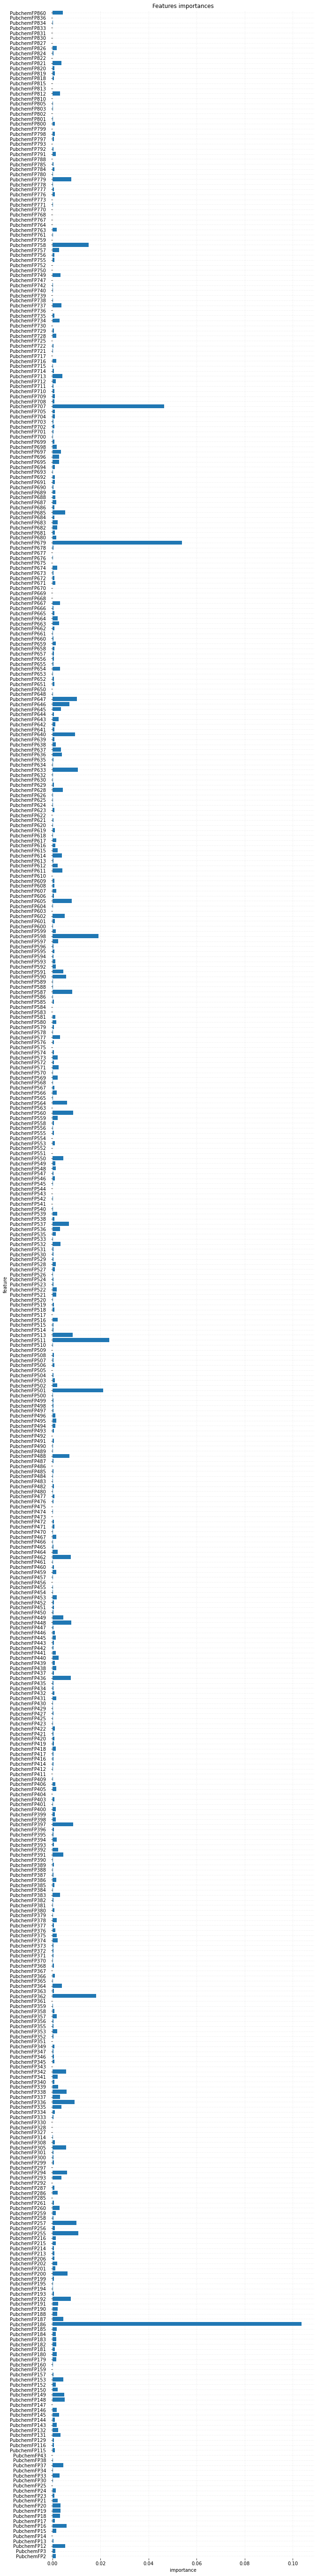

In [21]:
fig, ax = plt.subplots(figsize=(10, 100))
ax.barh(list(X_train.columns), rf_best.feature_importances_)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [22]:
results_df = results_df.append(pd.DataFrame(data=[["Random Forest Regressor", *evaluate(y_test, rf_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,11.861571,293.142026,17.121391,0.364781
1,Random Forest Regressor,10.602658,254.037203,15.938545,0.449519


## 5.3. XGBoost

Better results - second model.

'max_depth': None --> overfitting

In [29]:
# default: 'booster': gbtree, 'eta': 0.3, 'gamma': 0, 'max_depth': 6 
params = {
    'eta': [0.001, 0.005, 0.01],
    'lambda': [0.4, 0.6, 0.8],
    'gamma': [0.1, 0.5, 0.8],
    'max_depth': [5, 10, 15],
    'n_estimators': [500, 1000, 1500, 2000],
    'min_child_weight': [80, 95, 120, 150],
    'colsample_bytree': [0.2],
    'subsample': [0.8, 0.9]   
}

grid = GridSearchCV(xgb.XGBRegressor(verbosity=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

xgbr = xgb.XGBRegressor(verbosity=0, max_depth=5) 
xgbr.fit(X_train, y_train)

xgbr_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, xgbr_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, xgbr.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, xgbr_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, xgbr.predict(X_train))


Best params:  {'colsample_bytree': 0.2, 'eta': 0.01, 'gamma': 0.1, 'lambda': 0.6, 'max_depth': 15, 'min_child_weight': 95, 'n_estimators': 2000, 'subsample': 0.9} 

Test set:
Tuned model:
MAE: 10.068910479465076
MSE: 228.00565229825955
RMSE: 15.099856035679927
R2 Square 0.5059273735753037 

Base model:
MAE: 9.134690686204868
MSE: 223.07326790456966
RMSE: 14.935637512492383
R2 Square 0.5166155126076586 

Train set:
Tuned model:
MAE: 7.91822157138502
MSE: 149.0988818775602
RMSE: 12.210605303487627
R2 Square 0.7118544290538608 

Base model:
MAE: 3.407315388412263
MSE: 33.578815663277815
RMSE: 5.794723087713322
R2 Square 0.9351062403074496 



In [30]:
params = {'colsample_bytree': 0.2, 'eta': 0.01, 'gamma': 0.1, 'lambda': 0.6, 'max_depth': 15, 
          'min_child_weight': 95, 'n_estimators': 2000, 'subsample': 0.9} 

xgbr_best = xgb.XGBRegressor(**params) 
xgbr_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, xgbr_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, xgbr_best.predict(X_train))

Test set:
MAE: 10.068910479465076
MSE: 228.00565229825955
RMSE: 15.099856035679927
R2 Square 0.5059273735753037 

Train set:
MAE: 7.91822157138502
MSE: 149.0988818775602
RMSE: 12.210605303487627
R2 Square 0.7118544290538608 



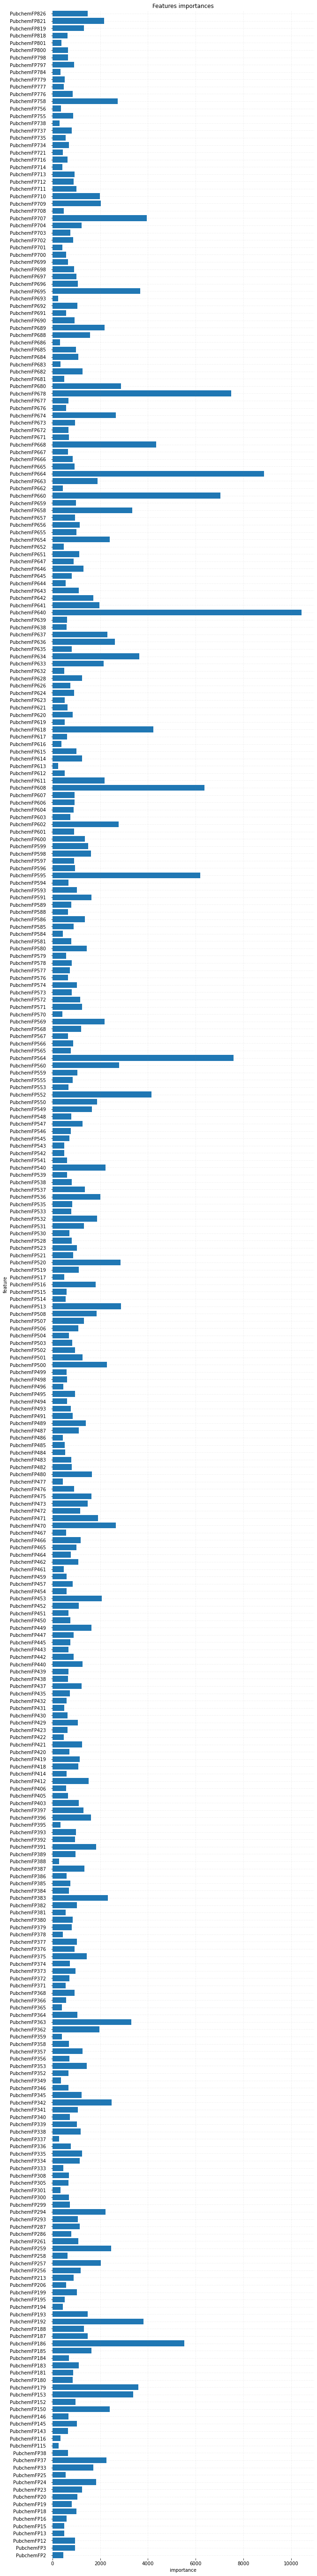

In [31]:
feature_importance = xgbr_best.get_booster().get_score(importance_type='gain')
keys = list(feature_importance.keys())
values = list(feature_importance.values())

fig, ax = plt.subplots(figsize=(10, 100))
ax.barh(keys, values)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [32]:
results_df = results_df.append(pd.DataFrame(data=[["XGBoost", *evaluate(y_test, xgbr_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,11.861571,293.142026,17.121391,0.364781
1,Random Forest Regressor,10.602658,254.037203,15.938545,0.449519
2,XGBoost,10.068910,228.005652,15.099856,0.505927


## 5.4. LightGBM

Better results - third model.

In [42]:
# default: 'n_estimators': 100, 'num_leaves': 31, 'learning_rate': 0.1, 'max_depth': -1 
params = {
    'num_leaves': [50, 60, 70, 80],
    'learning_rate': [0.001, 0.005, 0.01],
    'max_depth': [5, 10, 15],
    'n_estimators': [1000, 1500, 2000],
    'min_child_samples': [30, 55, 65, 95],
    'reg_alpha': [1.7, 2.7, 3.7],
    'reg_lambda': [0.04, 0.1],
    'colsample_bytree': [0.25],
    'subsample': [0.9],
    'cat_smooth': [28],
}

grid = GridSearchCV(lgbm.LGBMRegressor(random_state=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

lgbm_reg = lgbm.LGBMRegressor(random_state=0)
lgbm_reg.fit(X_train,y_train)

lgbm_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, lgbm_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, lgbm_reg.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, lgbm_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, lgbm_reg.predict(X_train))

Best params:  {'cat_smooth': 28, 'colsample_bytree': 0.25, 'learning_rate': 0.01, 'max_depth': 15, 'min_child_samples': 95, 'n_estimators': 2000, 'num_leaves': 60, 'reg_alpha': 1.7, 'reg_lambda': 0.04, 'subsample': 0.9} 

Test set:
Tuned model:
MAE: 9.865909829991155
MSE: 221.50134214148468
RMSE: 14.882921156193923
R2 Square 0.520021768033713 

Base model:
MAE: 8.875853608185354
MSE: 190.80575335540266
RMSE: 13.813245576453156
R2 Square 0.5865370057847192 

Train set:
Tuned model:
MAE: 7.564890596559274
MSE: 136.4151852524227
RMSE: 11.679691145420872
R2 Square 0.7363666920549954 

Base model:
MAE: 5.09632427920117
MSE: 65.9344499254902
RMSE: 8.12000307422911
R2 Square 0.8725763769683952 



In [43]:
params = {'cat_smooth': 28, 'colsample_bytree': 0.25, 'learning_rate': 0.01, 'max_depth': 15, 
          'min_child_samples': 95, 'n_estimators': 2000, 'num_leaves': 60, 'reg_alpha': 1.7, 'reg_lambda': 0.04, 
          'subsample': 0.9}

lgbm_best = lgbm.LGBMRegressor(**params) 
lgbm_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, lgbm_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, lgbm_best.predict(X_train))

Test set:
MAE: 9.883226091940498
MSE: 220.5647697999268
RMSE: 14.85142315739225
R2 Square 0.5220512561273893 

Train set:
MAE: 7.611453086406692
MSE: 136.75341445409552
RMSE: 11.694161554130144
R2 Square 0.7357130369423655 



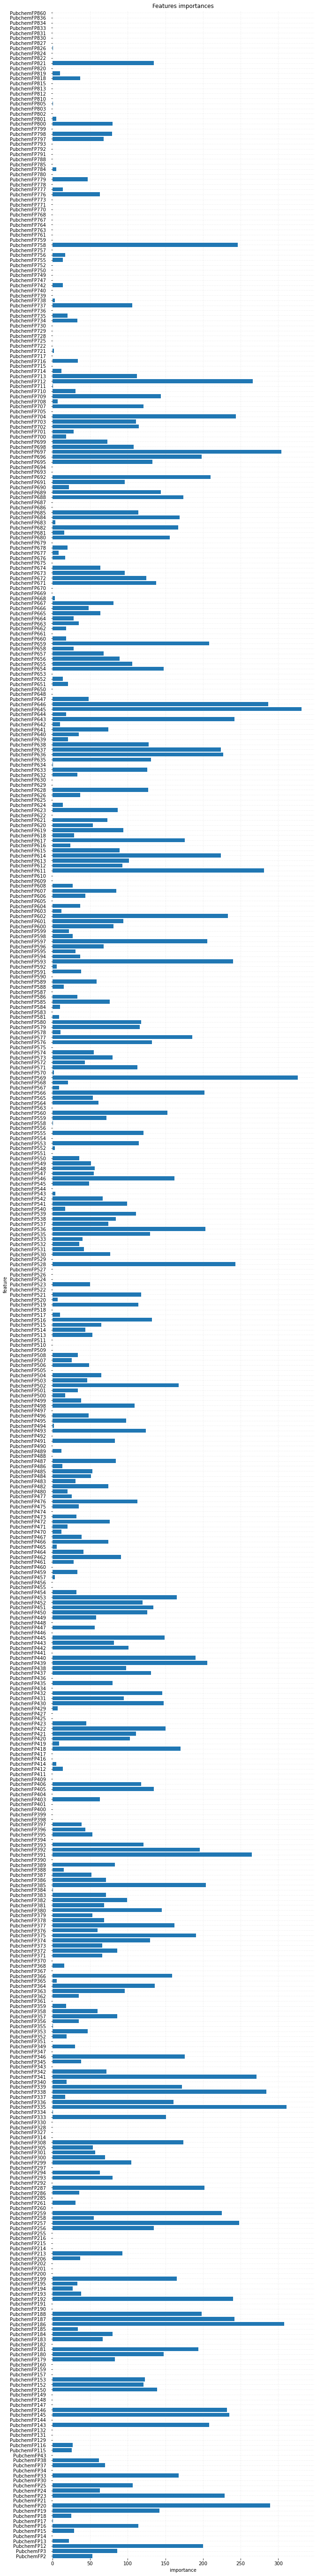

In [44]:
fig, ax = plt.subplots(figsize=(10, 100))
ax.barh(list(X_train.columns), lgbm_best.feature_importances_)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [45]:
results_df = results_df.append(pd.DataFrame(data=[["LightGBM", *evaluate(y_test, lgbm_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,11.861571,293.142026,17.121391,0.364781
1,Random Forest Regressor,10.602658,254.037203,15.938545,0.449519
2,XGBoost,10.068910,228.005652,15.099856,0.505927
3,LightGBM,9.883226,220.564770,14.851423,0.522051


## 5.5. Histogram-based Gradient Boosting Regressor (Regression Tree)

Better results - fourth model.

In [53]:
# default: 'learning_rate': 0.1, 'max_depth': None , 'l2_regularization': 0
params = {
    'learning_rate': [0.005, 0.1, 0.15],
    'max_depth': [2, 3, 5],
    'l2_regularization': [0, 0.01, 0.05],
    'min_samples_leaf':[15, 20, 25],
}

grid = GridSearchCV(HistGradientBoostingRegressor(random_state=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

hist_reg = HistGradientBoostingRegressor(random_state=0)
hist_reg.fit(X_train,y_train)

hist_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, hist_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, hist_reg.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, hist_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, hist_reg.predict(X_train))

Best params:  {'l2_regularization': 0.01, 'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 15} 

Test set:
Tuned model:
MAE: 9.665940305961977
MSE: 220.74306228088258
RMSE: 14.857424483431931
R2 Square 0.5216649085371008 

Base model:
MAE: 8.875853601913215
MSE: 190.805753523139
RMSE: 13.813245582524731
R2 Square 0.5865370054212461 

Train set:
Tuned model:
MAE: 7.3574257417634925
MSE: 135.62209971663373
RMSE: 11.645690177771076
R2 Square 0.7378993935859612 

Base model:
MAE: 5.096324277942109
MSE: 65.93444995153362
RMSE: 8.120003075832768
R2 Square 0.8725763769180642 



In [54]:
params = {'l2_regularization': 0.01, 'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 15} 

hist_best = HistGradientBoostingRegressor(random_state=0, **params) 
hist_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, hist_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, hist_best.predict(X_train))

Test set:
MAE: 9.665940305961977
MSE: 220.74306228088258
RMSE: 14.857424483431931
R2 Square 0.5216649085371008 

Train set:
MAE: 7.3574257417634925
MSE: 135.62209971663373
RMSE: 11.645690177771076
R2 Square 0.7378993935859612 



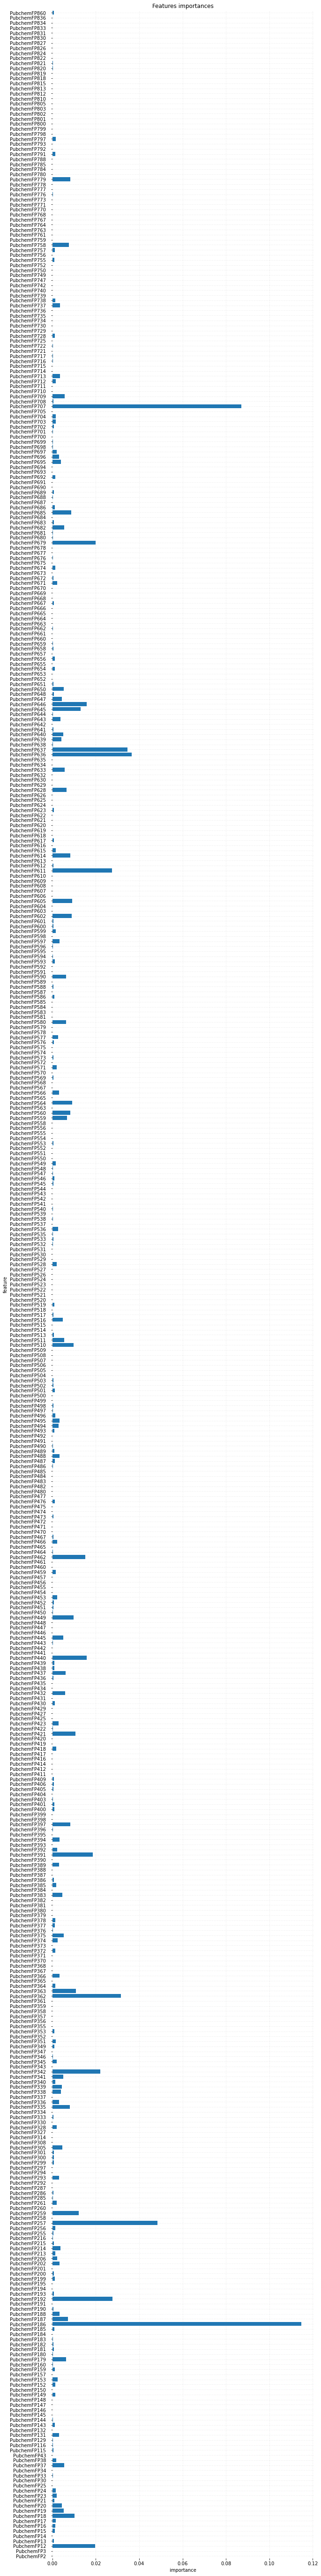

In [55]:
feature_importance = permutation_importance(hist_best, X_train, y_train, n_repeats=15, random_state=0)
fig, ax = plt.subplots(figsize=(10, 100))
ax.barh(list(X_train.columns), feature_importance.importances_mean)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [56]:
results_df = results_df.append(pd.DataFrame(data=[["HistGradient Boosting Regressor", *evaluate(y_test, hist_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,11.861571,293.142026,17.121391,0.364781
1,Random Forest Regressor,10.602658,254.037203,15.938545,0.449519
2,XGBoost,10.068910,228.005652,15.099856,0.505927
3,LightGBM,9.883226,220.564770,14.851423,0.522051
4,HistGradient Boosting Regressor,9.665940,220.743062,14.857424,0.521665


## 5.6. Support Vector Regression

Better results - fifth model.

In [60]:
# default: 'kernel': 'rbf', 'gamma': 'scale', 'C': 1.0, 'epsilon': 0.1
params = {
    'kernel': ['rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'C': [15.0, 30.0, 35.0],
    'epsilon': [2.8, 3.8, 4.8, 6.8],
}
               
grid = GridSearchCV(SVR(), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

svr = SVR()
svr.fit(X_train,y_train)

svr_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, svr_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, svr.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, svr_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, svr.predict(X_train))

Best params:  {'C': 35.0, 'epsilon': 6.8, 'gamma': 'scale', 'kernel': 'rbf'} 

Test set:
Tuned model:
MAE: 9.743970077291303
MSE: 232.84873658226687
RMSE: 15.259381920060422
R2 Square 0.49543274176211716 

Base model:
MAE: 10.754268196502137
MSE: 462.010010531442
RMSE: 21.49441812497938
R2 Square -0.001144037601183534 

Train set:
Tuned model:
MAE: 7.987343180090928
MSE: 174.1610757289719
RMSE: 13.19701010566302
R2 Square 0.6634197254159879 

Base model:
MAE: 10.985109744950968
MSE: 513.3196667237515
RMSE: 22.65655902214084
R2 Square 0.007968493234835616 



In [61]:
params = {'C': 35.0, 'epsilon': 6.8, 'gamma': 'scale', 'kernel': 'rbf'} 

svr_best = SVR(**params) 
svr_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, svr_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, svr_best.predict(X_train))

Test set:
MAE: 9.743970077291303
MSE: 232.84873658226687
RMSE: 15.259381920060422
R2 Square 0.49543274176211716 

Train set:
MAE: 7.987343180090928
MSE: 174.1610757289719
RMSE: 13.19701010566302
R2 Square 0.6634197254159879 



In [63]:
feature_importance = permutation_importance(svr_best, X_train, y_train, n_repeats=5, random_state=0)
fig, ax = plt.subplots(figsize=(10, 100))
ax.barh(list(X_train.columns), feature_importance.importances_mean)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

'\nfeature_importance = permutation_importance(svr_best, X_train, y_train, n_repeats=5, random_state=0)\nfig, ax = plt.subplots(figsize=(10, 100))\nax.barh(list(X_train.columns), feature_importance.importances_mean)\n\nfor s in [\'top\', \'bottom\', \'left\', \'right\']:\n    ax.spines[s].set_visible(False)\nax.yaxis.set_tick_params(pad=10)\nplt.margins(y=0)\nax.grid(b=True, color=\'grey\',linestyle=\'-.\', linewidth=0.5,alpha=0.2)\nax.set_xlabel("importance")\nax.set_ylabel("feature")\nax.set_title("Features importances")\nplt.show()\n'

In [64]:
results_df = results_df.append(pd.DataFrame(data=[["Support Vector Regression", *evaluate(y_test, svr_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,11.861571,293.142026,17.121391,0.364781
1,Random Forest Regressor,10.602658,254.037203,15.938545,0.449519
2,XGBoost,10.068910,228.005652,15.099856,0.505927
3,LightGBM,9.883226,220.564770,14.851423,0.522051
4,HistGradient Boosting Regressor,9.665940,220.743062,14.857424,0.521665
5,Support Vector Regression,9.743970,232.848737,15.259382,0.495433


### Save models

In [118]:
'''
pickle.dump(rf_best, open('models/rf.pkl', 'wb'))
pickle.dump(xgbr_best, open('models/xgb.pkl', 'wb'))
pickle.dump(lgbm_best, open('models/lgbm.pkl', 'wb'))
pickle.dump(hist_best, open('models/hist.pkl', 'wb'))
pickle.dump(svr_best, open('models/svr.pkl', 'wb'))
'''

"\npickle.dump(rf_best, open('models/rf.pkl', 'wb'))\npickle.dump(xgbr_best, open('models/xgb.pkl', 'wb'))\npickle.dump(lgbm_best, open('models/lgbm.pkl', 'wb'))\npickle.dump(hist_best, open('models/hist.pkl', 'wb'))\npickle.dump(svr_best, open('models/svr.pkl', 'wb'))\n"

## 5.7. Stacking models

### Averaging base models

In [66]:
def average_predictions(X):
    return ((0.10 * rf_best.predict(X)) + \
            (0.20 * xgbr_best.predict(X)) + \
            (0.25 * lgbm_best.predict(X)) + \
            (0.25 * hist_best.predict(X)) + \
            (0.20 * svr_best.predict(X)))

print('Test set:')
print_evaluate(y_test, average_predictions(X_test))
print('Train set:')
print_evaluate(y_train, average_predictions(X_train))

Test set:
MAE: 9.572547749348836
MSE: 216.24163848391058
RMSE: 14.705156867028334
R2 Square 0.5314191854841972 

Train set:
MAE: 7.423186060564918
MSE: 138.66305679449988
RMSE: 11.775527877530582
R2 Square 0.7320224996589899 



In [67]:
results_df = results_df.append(pd.DataFrame(data=[["Averaging base models", *evaluate(y_test, average_predictions(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,11.861571,293.142026,17.121391,0.364781
1,Random Forest Regressor,10.602658,254.037203,15.938545,0.449519
2,XGBoost,10.068910,228.005652,15.099856,0.505927
3,LightGBM,9.883226,220.564770,14.851423,0.522051
4,HistGradient Boosting Regressor,9.665940,220.743062,14.857424,0.521665
5,Support Vector Regression,9.743970,232.848737,15.259382,0.495433
6,Averaging base models,9.572548,216.241638,14.705157,0.531419


### Averaging base models with Meta-model

In [68]:
meta_train = pd.DataFrame(data={
    "rf": rf_best.predict(X_train).tolist(),
    "xgbr": xgbr_best.predict(X_train).tolist(),
    "lgbm": lgbm_best.predict(X_train).tolist(),
    "hist_reg": hist_best.predict(X_train).tolist(),
    "svr_reg": svr_best.predict(X_train).tolist()
    })

    
meta_test = pd.DataFrame(data={
    "rf": rf_best.predict(X_test).tolist(),
    "xgbr": xgbr_best.predict(X_test).tolist(),
    "lgbm": lgbm_best.predict(X_test).tolist(),
    "hist_reg": hist_best.predict(X_test).tolist(),
    "svr_reg": svr_best.predict(X_test).tolist()
    })


In [69]:
meta_train

,rf,xgbr,lgbm,hist_reg,svr_reg
0,91.517012,84.504318,85.192596,90.261274,85.233934
1,91.719137,87.989487,88.902801,99.586411,92.290989
2,96.529387,99.002739,99.771210,98.737617,94.010354
3,95.551006,94.373169,95.487216,100.267671,92.396015
4,94.934469,94.578300,94.949672,89.162820,90.199796
...,...,...,...,...,...
2125,87.270362,90.212685,91.088937,92.638383,91.000021
2126,88.648008,97.783615,97.080743,93.423461,98.640486
2127,89.417598,89.654236,88.089160,96.298302,93.199974
2128,83.626676,70.923256,70.204534,71.705981,70.934600


In [70]:
params = {'alpha': 0.1} 

meta_model = Ridge(**params)
meta_model.fit(meta_train, y_train)

print('Test set:')
print_evaluate(y_test, meta_model.predict(meta_test))

print('Train set:')
print_evaluate(y_train, meta_model.predict(meta_train))

Test set:
MAE: 9.85430625402332
MSE: 214.80424149515235
RMSE: 14.656201468837427
R2 Square 0.5345339262737007 

Train set:
MAE: 6.802017528921962
MSE: 104.49002774593372
RMSE: 10.222036379603319
R2 Square 0.7980646244701223 



In [71]:
results_df = results_df.append(pd.DataFrame(data=[["Base models + Meta-model", *evaluate(y_test, meta_model.predict(meta_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,11.861571,293.142026,17.121391,0.364781
1,Random Forest Regressor,10.602658,254.037203,15.938545,0.449519
2,XGBoost,10.068910,228.005652,15.099856,0.505927
3,LightGBM,9.883226,220.564770,14.851423,0.522051
4,HistGradient Boosting Regressor,9.665940,220.743062,14.857424,0.521665
5,Support Vector Regression,9.743970,232.848737,15.259382,0.495433
6,Averaging base models,9.572548,216.241638,14.705157,0.531419
7,Base models + Meta-model,9.854306,214.804241,14.656201,0.534534


### Averaging base models with Meta-model and k-fold cross validation

![Stacked](images/stacked.png)

In [72]:
params_rf = {'max_depth': 8, 'n_estimators': 2000} 

params_xgb = {'colsample_bytree': 0.2, 'eta': 0.01, 'gamma': 0.1, 'lambda': 0.6, 'max_depth': 15, 
          'min_child_weight': 95, 'n_estimators': 2000, 'subsample': 0.9} 

params_lgbm = {'cat_smooth': 28, 'colsample_bytree': 0.25, 'learning_rate': 0.01, 'max_depth': 15, 
          'min_child_samples': 95, 'n_estimators': 2000, 'num_leaves': 60, 'reg_alpha': 1.7, 'reg_lambda': 0.04, 
          'subsample': 0.9}

params_hist =  {'l2_regularization': 0.01, 'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 15}   

params_svr = {'C': 35.0, 'epsilon': 6.8, 'gamma': 'scale', 'kernel': 'rbf'} 

In [73]:
pred1 = np.zeros(X_train.shape[0])
pred2 = np.zeros(X_train.shape[0])
pred3 = np.zeros(X_train.shape[0])
pred4 = np.zeros(X_train.shape[0])
pred5 = np.zeros(X_train.shape[0])
models1 = []
models2 = []
models3 = []
models4 = []
models5 = []

kf = KFold(n_splits=6,random_state=48,shuffle=True)
n_fold = 0

for trn_idx, test_idx in kf.split(X_train, y_train):
    print(f"-------------- fold {n_fold+1} --------------")
    X_tr,X_val = X_train.iloc[trn_idx],X_train.iloc[test_idx]
    y_tr,y_val = y_train.iloc[trn_idx],y_train.iloc[test_idx]
     
    model1 = RandomForestRegressor(**params_rf)
    model1.fit(X_tr,y_tr)
    models1.append(model1)
    #pickle.dump(model1, open('models/stacked/m1{}.pkl'.format(n_fold+1), 'wb'))
    pred1[test_idx] = model1.predict(X_val)
    mse1 = mean_squared_error(y_val, pred1[test_idx])
    r21 = r2_score(y_val, pred1[test_idx])
    print("Model1 MSE: {}".format(mse1))
    print("Model1 R2: {}".format(r21))

    model2 = xgb.XGBRegressor(**params_xgb)
    model2.fit(X_tr,y_tr)
    models2.append(model2)
    #pickle.dump(model2, open('models/stacked/m2{}.pkl'.format(n_fold+1), 'wb'))
    pred2[test_idx] = model2.predict(X_val)
    mse2 = mean_squared_error(y_val, pred2[test_idx])
    r22 = r2_score(y_val, pred2[test_idx])
    print("Model2 MSE: {}".format(mse2))
    print("Model2 R2: {}".format(r22))
    
    model3 = lgbm.LGBMRegressor(**params_lgbm)
    model3.fit(X_tr,y_tr)
    models3.append(model3)
    #pickle.dump(model3, open('models/stacked/m3{}.pkl'.format(n_fold+1), 'wb'))
    pred3[test_idx] = model3.predict(X_val)
    mse3 = mean_squared_error(y_val, pred3[test_idx])
    r23 = r2_score(y_val, pred3[test_idx])
    print("Model3 MSE: {}".format(mse3))
    print("Model3 R2: {}".format(r23))
    
    model4 = HistGradientBoostingRegressor(**params_hist)
    model4.fit(X_tr,y_tr)
    models4.append(model4)
    #pickle.dump(model4, open('models/stacked/m4{}.pkl'.format(n_fold+1), 'wb'))
    pred4[test_idx] = model4.predict(X_val)
    mse4 = mean_squared_error(y_val, pred4[test_idx])
    r24 = r2_score(y_val, pred4[test_idx])
    print("Model4 MSE: {}".format(mse4))
    print("Model4 R2: {}".format(r24))
    
    model5 = SVR(**params_svr)
    model5.fit(X_tr,y_tr)
    models5.append(model5)
    #pickle.dump(model5, open('models/stacked/m5{}.pkl'.format(n_fold+1), 'wb'))
    pred5[test_idx] = model5.predict(X_val)
    mse5 = mean_squared_error(y_val, pred5[test_idx])
    r25 = r2_score(y_val, model5.predict(X_val))
    print("Model5 MSE: {}".format(mse5))
    print("Model5 R2: {}".format(r25))
           
    print("Average MSE = {}".format((mse1+mse2+mse3+mse4+mse5)/5))
    print("Average R2 = {}".format((r21+r22+r23+r24+r25)/5))

    n_fold+=1

-------------- fold 1 --------------
Model1 MSE: 294.98565234048266
Model1 R2: 0.4150455533354376
Model2 MSE: 275.3666515598917
Model2 R2: 0.4539498920877373
Model3 MSE: 270.2139498740538
Model3 R2: 0.46416766281506694
Model4 MSE: 277.0327214472638
Model4 R2: 0.4506460873726952
Model5 MSE: 291.1734678126846
Model5 R2: 0.4226050880902583
Average MSE = 281.75448860687527
Average R2 = 0.4412828567402391
-------------- fold 2 --------------
Model1 MSE: 339.25810528935705
Model1 R2: 0.3694547033019797
Model2 MSE: 269.8444432166294
Model2 R2: 0.4984669729107296
Model3 MSE: 266.10379604865614
Model3 R2: 0.5054193417461346
Model4 MSE: 263.7989133322826
Model4 R2: 0.5097031980006825
Model5 MSE: 306.0240808678261
Model5 R2: 0.43122347894101776
Average MSE = 289.00586775095024
Average R2 = 0.46285353898010884
-------------- fold 3 --------------
Model1 MSE: 294.71557190935613
Model1 R2: 0.4707658976856265
Model2 MSE: 280.9704687761608
Model2 R2: 0.4954486019987614
Model3 MSE: 274.04867496554056
M

In [74]:
test1 = np.zeros(X_test.shape[0])
test2 = np.zeros(X_test.shape[0])
test3 = np.zeros(X_test.shape[0])
test4 = np.zeros(X_test.shape[0])
test5 = np.zeros(X_test.shape[0])

n_splits = kf.n_splits

for model_id in range(n_splits):
    test1 += models1[model_id].predict(X_test)/n_splits
    test2 += models2[model_id].predict(X_test)/n_splits
    test3 += models3[model_id].predict(X_test)/n_splits
    test4 += models4[model_id].predict(X_test)/n_splits
    test5 += models5[model_id].predict(X_test)/n_splits

In [75]:
meta_train2 = pd.DataFrame(data={
    "rf": pred1.tolist(),
    "xgbr": pred2.tolist(),
    "lgbm": pred3.tolist(),
    "hist_reg": pred4.tolist(),
    "svr_reg": pred5.tolist(),
    })
meta_test2 = pd.DataFrame(data={
    "rf": test1.tolist(),
    "xgbr": test2.tolist(),
    "lgbm": test3.tolist(),
    "hist_reg": test4.tolist(),
    "svr_reg": test5.tolist()
    })

In [76]:
meta_train2

,rf,xgbr,lgbm,hist_reg,svr_reg
0,91.073145,83.877739,81.216939,93.689111,86.420133
1,90.197445,87.345772,83.994194,100.794530,92.281011
2,96.946500,101.670166,103.060190,99.121261,98.112930
3,95.248648,92.949547,94.797952,97.365165,92.047547
4,94.617958,90.874695,91.195245,91.786293,87.476715
...,...,...,...,...,...
2125,86.843062,89.826744,91.209984,92.212278,90.373298
2126,89.075179,98.786613,97.759000,95.814688,99.641607
2127,87.027625,83.914963,83.316728,92.463472,86.070033
2128,85.326363,73.056999,74.276949,75.574464,75.573331


In [77]:
meta_test2

,rf,xgbr,lgbm,hist_reg,svr_reg
0,95.983130,101.403233,101.987099,101.649688,97.911994
1,87.644201,90.227044,91.473867,91.726873,90.284265
2,80.602665,69.422449,72.026165,81.343414,78.465030
3,91.714462,99.282116,100.383670,100.020488,98.147469
4,85.183149,75.062402,75.544212,81.312376,79.209597
...,...,...,...,...,...
528,91.061148,99.761561,97.769847,90.576674,92.874692
529,56.148181,84.396831,84.526423,90.234323,83.519988
530,84.159804,87.581929,87.529454,90.581979,92.798947
531,79.203585,77.969068,78.761604,70.766728,78.547540


In [81]:
params = {'alpha': 0.1} 

meta_model2 = Ridge(**params)
meta_model2.fit(meta_train2, y_train)

print('Test set:')
print_evaluate(y_test, meta_model2.predict(meta_test2))

print('Train set:')
print_evaluate(y_train, meta_model2.predict(meta_train2))

Test set:
MAE: 9.726411080426566
MSE: 220.08616939666712
RMSE: 14.835301459581707
R2 Square 0.5230883504093202 

Train set:
MAE: 9.979943010281838
MSE: 251.10283656854574
RMSE: 15.846224678722239
R2 Square 0.5147235894856954 



In [82]:
results_df = results_df.append(pd.DataFrame(data=[["Base models + Meta-model + cv", *evaluate(y_test, meta_model2.predict(meta_test2))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,11.861571,293.142026,17.121391,0.364781
1,Random Forest Regressor,10.602658,254.037203,15.938545,0.449519
2,XGBoost,10.068910,228.005652,15.099856,0.505927
3,LightGBM,9.883226,220.564770,14.851423,0.522051
4,HistGradient Boosting Regressor,9.665940,220.743062,14.857424,0.521665
5,Support Vector Regression,9.743970,232.848737,15.259382,0.495433
6,Averaging base models,9.572548,216.241638,14.705157,0.531419
7,Base models + Meta-model,9.854306,214.804241,14.656201,0.534534
8,Base models + Meta-model + cv,9.726411,220.086169,14.835301,0.523088
